# Lab 6: Convolutional Neural Networks

### Katherine Wirskye, Lucas Li, Ethan Li, and Kaylie Nguyen (5000-level students)

Link to dataset: **insert this shi**

## Preparation

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # so that I don't use GPU
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable all GPUs

import numpy as np
import matplotlib.pylab as plt

#import pandas as pd
# from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Model
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.regularizers import l2

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [3]:
# locate directories
folder = "allimages"

image_directories = [
    os.path.join(folder, "angry"),
    os.path.join(folder, "disgust"),
    os.path.join(folder, "fear"),
    os.path.join(folder, "happy"),
    os.path.join(folder, "neutral"),
    os.path.join(folder, "sad"),
    os.path.join(folder, "surprise")
]

# function to get image paths and the emotion label
def get_image_paths_and_labels(image_directories):
    image_paths = [] #stores image paths
    labels = [] #stores labels

    # goes through each of the 7 directories 
    for i, directory in enumerate(image_directories):
        emotion_label = os.path.basename(directory) # captures the emotion label
        # goes through each image in each directory
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_paths.append(os.path.join(directory, filename)) #appends image path to list
                labels.append(emotion_label) # appends emotion label to list

    return image_paths, labels

# gets image path and label for training and testing set
image_paths, image_labels = get_image_paths_and_labels(image_directories)

print("Number of images:", len(image_paths))
print("Number of labels:", len(image_labels))

Number of images: 35685
Number of labels: 35685


In [4]:
def load_and_preprocess_images(image_paths, img_width, img_height):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

img_width = 48
img_height = 48

X = load_and_preprocess_images(image_paths, img_width, img_height)

label_encoder = LabelEncoder()

# Fit and transform the labels for training data
labels_encoded = label_encoder.fit_transform(image_labels)

# Convert the encoded labels to one-hot encoded vectors
y = to_categorical(labels_encoded)

print(len(X), len(y))

35685 35685


### Performance Metric

**discuss choice here**

### Data Splitting Method

**discuss choice here**

In [5]:
# define the 5-fold stratified cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# we can probably changes this to 10 later (10 is probably better for statistical test)

## Modeling

### Data Expansion

I think we're just gonna add the layers actually in the models. I've added some layers for the first one. So we can just talk about the data expansion here :D

So far, we have:
- random horizontal flip
- random rotation
- random translation
- random zoom

*Setup the training to use data expansion in Keras (also called data augmentation). 
Explain why the chosen data expansion techniques are appropriate for your dataset. 
You should make use of Keras augmentation layers, like in the class examples.*

### Model 1

Kaylie pls add description of how this model works thank you!

In [6]:
# for tracking performance
training_results_model1_1 = []
testing_results_model1_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # Kaylie's code yay!
    # build a model
    input_shape = (img_width, img_height, 3)

    model1_1 = Sequential([

        # data expansion and augmentation (should be talked abt previously)
        # these might be decreasing accuracy (I don't know if they're contradicting the pre processing Kaylie did)
        # need to discuss this ^^
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model architecture
        # can she write a summary of this?
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # traing the model
    history = model1_1.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    # add verbose = 0 later!!

    # track accuracy and loss for training data and validation data
    training_results_model1_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = model1_1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model1_1.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/20
357/357 [==============================] - 34s 92ms/step - loss: 1.8059 - accuracy: 0.2530 - val_loss: 1.7885 - val_accuracy: 0.2553
Epoch 2/20
357/357 [==============================] - 32s 90ms/step - loss: 1.7331 - accuracy: 0.2942 - val_loss: 1.7967 - val_accuracy: 0.2282
Epoch 3/20
357/357 [==============================] - 34s 94ms/step - loss: 1.6649 - accuracy: 0.3251 - val_loss: 1.5983 - val_accuracy: 0.3739
Epoch 4/20
357/357 [==============================] - 35s 97ms/step - loss: 1.5906 - accuracy: 0.3720 - val_loss: 1.5072 - val_accuracy: 0.4158
Epoch 5/20
357/357 [==============================] - 36s 100ms/step - loss: 1.5354 - accuracy: 0.4011 - val_loss: 1.6590 - val_accuracy: 0.3443
Epoch 6/20
357/357 [==============================] - 36s 101ms/step - loss: 1.5028 - accuracy: 0.4161 - val_loss: 1.4760 - val_accuracy: 0.4284
Epoch 7/20
357/357 [==============================] - 37s 104ms/step - loss: 1.4736 - accuracy: 0.4270 - val_loss: 1.4502 - val_accura

##### Loss Across Training Iterations

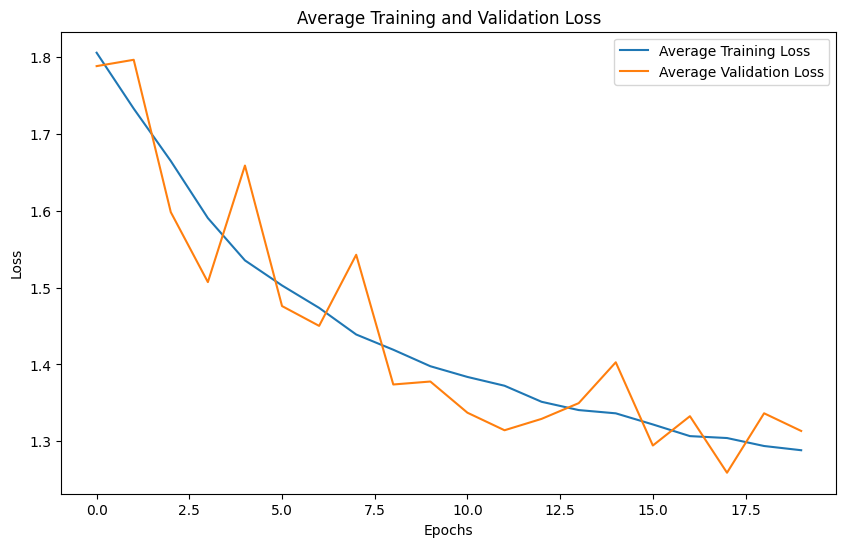

In [7]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model1_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss1_1 = []
avg_val_loss1_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model1_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model1_1]
    
    avg_loss1_1.append(np.mean(epoch_loss))
    avg_val_loss1_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss1_1, label='Average Training Loss')
plt.plot(avg_val_loss1_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

##### Performance Across Training Iterations

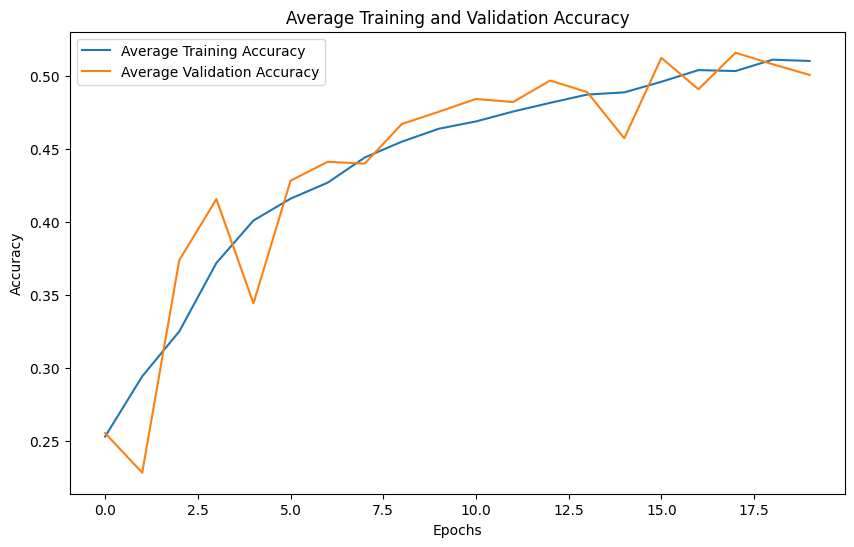

In [8]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy1_1 = []
avg_val_accuracy1_1 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model1_1]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model1_1]
    
    avg_accuracy1_1.append(np.mean(epoch_accuracy))
    avg_val_accuracy1_1.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy1_1, label='Average Training Accuracy')
plt.plot(avg_val_accuracy1_1, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

##### Testing Performance

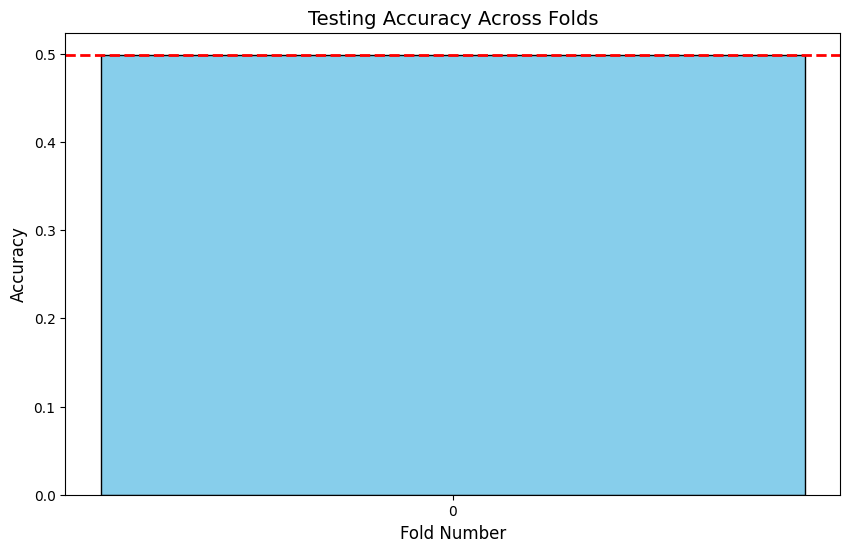

Average Accuracy:  0.49880900979042053
Standard Deviation:  0.0


In [9]:
# Calculate the average tseting accuracy
average1_1 = np.mean(testing_results_model1_1)
std1_1 = np.std(testing_results_model1_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_1)), testing_results_model1_1, color='skyblue', edgecolor='black', label='Values')

# Plot the average as a horizontal line
plt.axhline(average1_1, color='red', linestyle='--', linewidth=2, label=f'Average ({average1_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Testing Accuracy Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_1)))

# Show the plot
plt.show()

# Print average and standard deviation for accuracy
print("Average Accuracy: ", average1_1)
print("Standard Deviation: " , std1_1)

#### Model 1 with Changed Parameters

### Model 2

In [ ]:
# for tracking performance
training_results_model2_1 = []
testing_results_model2_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS

    input_shape = (img_width, img_height, 3)

    model2_1 = Sequential([

        # data expansion and augmentation (should be talked abt previously)
        # these might be decreasing accuracy (I don't know if they're contradicting the pre processing Kaylie did)
        # need to discuss this ^^
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model architecture
        # can she write a summary of this?
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model2_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # traing the model
    history = model2_1.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    # add verbose = 0 later!!

    # track accuracy and loss for training data and validation data
    training_results_model2_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = model2_1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model2_1.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

In [ ]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model2_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss2_1 = []
avg_val_loss2_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model2_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model2_1]
    
    avg_loss1_1.append(np.mean(epoch_loss))
    avg_val_loss2_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss2_1, label='Average Training Loss')
plt.plot(avg_val_loss2_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

#### Model 2 with Changed Parameters

### Performance Comparison